# 1. Introducción



## Fuga de clientes

En la Industria de “Servicios” se puede identificar claramente el “Inicio “y “Fin” de una relación 
contractual con un cliente. Sin embargo, en en el Retail en general no existe formalmente 
un Inicio o Fin de esta relación entre el cliente y la Empresa. Por tanto, la definición de Fuga se debe construir a partir de variables de Frecuencia de juego y Recencia. Sin embargo, la dificultad radica en que los distintos segmentos de 
clientes no tienen el mismo comportamiento, dentro de un mismo segmento cada cliente puede presentar una frecuencia de consumo distinta.

El desafio de este proyecto es realizar un modelo de Fuga personalizado para cada cliente basado en los tiempos entre visita.

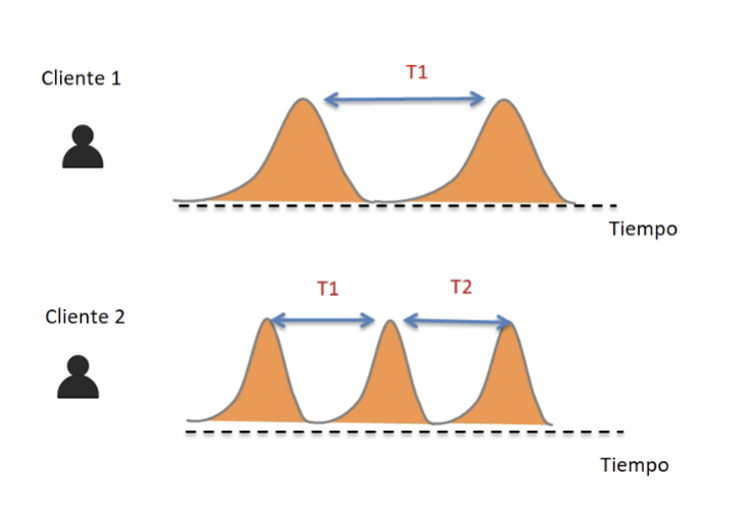

# 2. Pregunta de Investigación


El presente trabajo tiene como objetivo responder las siguientes preguntas:

1. ¿Es posible crear una distribución de tiempo entre visita por cliente? ¿Cuantos clientes tienen más 10 visitas para construir una distribución personalizada? 


2. ¿Cuál es el promedio, media, moda y percentiles del Tiempo Entre Visita de cada cliente?  


3. ¿Existen una diferencia en el Tiempo Entre Visita según la categoría de cliente? Es decir ¿cual la diferencia del promedio de promedios de este indicador?  

    **Hipotesis: Mientras mayor sea la categoria del cliente, menor será su tiempo entre visita. Es decir, a mayor frecuente es esperada.**   


 
3. ¿Cuál es la distribución de probabilidad para el TEV agrupado por categoria cliente?  



4. ¿Existen clientes que presente una distribución bimodal en el TEV?  


# 3. Dataset (BBDD)

Los dataset a utilizar corresponde a clientes y transacciones. El ID de cliente fue encriptado por razones de proteccion y privacidad de datos personales. 

El dataset df_clientes esta compuesto por 5 campos:

- id : Indentificador de cliente encriptado
- GENERO: Genero del cliente, H: Mobres, M: Mujeres
- EDAD: Edad del cliente
- RANGO_ETARIO: Rango discreto calculado a partir de la edad del cliente
- CATEGORIA: Categoria o segmentación de valor del cliente. 

El dataset df_transacciones está compuesto por 2 campos:

- id : Indentificador de cliente encriptado
- Fecha: Fecha de la visita.

La BBDD contiene 134.000 usuarios unicos que tengan al menos con un total de 1.000.000 de transacciones.


## 3.1. Exploración del Dataset 

### Librerias

In [172]:
import pandas as pd
import numpy as np
import scipy
from scipy import signal
from scipy import stats
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
from multiprocess import Pool, cpu_count
from datetime import datetime
import seaborn as sns
from scipy.spatial import distance

### Importar Datos en CSV

In [26]:
df_clientes=pd.read_csv('clientes.csv', sep=';')

In [27]:
df_clientes.head()

,id,GENERO,EDAD,RANGO_ETARIO,CATEGORIA
0,130063303,H,53.0,45-64,Categoria_1
1,130179189,H,23.0,18-24,Categoria_1
2,130139656,M,31.0,30-44,Categoria_1
3,130059736,M,41.0,30-44,Categoria_1
4,130154916,M,28.0,25-29,Categoria_1


In [28]:
df_clientes.shape

(134540, 5)

In [29]:
df_transacciones=pd.read_csv('transacciones.csv', sep=';')

In [30]:
df_transacciones.head()

,id,val,Fecha
0,10003,481,20220317
1,10003,35682,20220505
2,10004,28,20220331
3,10004,3,20220413
4,10004,6,20220415


In [31]:
df_transacciones['Fecha']=df_transacciones['Fecha'].astype(int) 
df_transacciones['Fecha']=pd.to_datetime(df_transacciones['Fecha'], format = '%Y%m%d')
df_transacciones.shape

(967757, 3)

### Analisis descriptivo del dataset Clientes

**Se filtraran los registros con missing values**

In [32]:
df_clientes.isna().sum()

id                 0
GENERO            33
EDAD            1803
RANGO_ETARIO    1803
CATEGORIA          0
dtype: int64

In [33]:
df_clientes=df_clientes.dropna()

### Analisis descriptivo del dataset Transacciones

In [38]:
df_transacciones['dia']=df_transacciones['Fecha'].dt.dayofweek
df_transacciones['fin_de_semana']=np.where((df_transacciones['dia']==5)|(df_transacciones['dia']==6),1,0)
df_transacciones['dia']=df_transacciones['dia'].replace({0:'1 Lunes',
                                                          1:'2 Martes',
                                                          2:'3 Miercoles',
                                                          3:'4 Jueves',
                                                          4:'5 Viernes',
                                                          5:'6 Sabado',
                                                          6:'7 Domingo'}
                                                         )
df_transacciones.head()

,id,val,Fecha,dia,fin_de_semana
0,10003,481,2022-03-17,4 Jueves,0
1,10003,35682,2022-05-05,4 Jueves,0
2,10004,28,2022-03-31,4 Jueves,0
3,10004,3,2022-04-13,3 Miercoles,0
4,10004,6,2022-04-15,5 Viernes,0


[Text(0.5, 1.0, 'Cantidad de visitas por dia de la semana')]

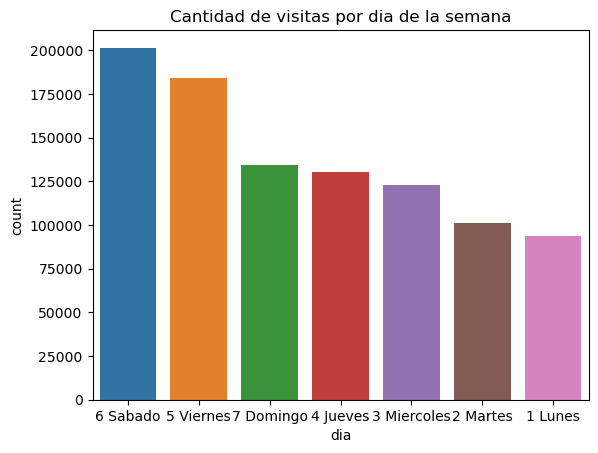

In [39]:
sns.countplot(x ='dia', data = df_transacciones,order=df_transacciones['dia'].value_counts().index).set(title='Cantidad de visitas por dia de la semana')

# 4. Metodología y Preprocesamiento

## 4.0 Metodología

- Luego de importar los datos se limpió el dataset filtrando aquellos clientes que tienen missing value y tambien aquellos que tienen una mala calidad de datos como es el caso de clientes con una edad mayor a 100 años



- Luego agruparemos las transacciones o visitas de cada cliente. Para esto crearemos una lista de dataframe, donde cada dataframe tendrá las visitas de un cliente en especifico. Para optimizar los tiempos de procesamiento y poder hacer un calculo distribuido en multiprocesos



- Posteriormente se calculará el Tiempo Entre cada una de las visitas para cada uno de los clientes  



- Luego se calcularán los estadigrafos descriptivos de Tiempo Entre Visita para cada cliente. Especificamente:
    - Media
    - Moda
    - Desviación Estandar
    - valor maximo
    - valor minimo
    - percentiles 25, 75 y 90




- Se calculará la distribución TEV por cateogira cliente de manera agrupada. Previo a esto se calculará el MAD (Mean Absolute Deviation) para filtrar clientes con muchos outliers 


- Finalmente se abordará la problematica de clientes que presenten una distribución bimodal, para esto se filtrarán aquellos clientes que tengan al menos 10 visitas. Finalmente se empleará la técnica de KDE Kernel Density Estimation para construir una función continua de probabilidad y luego sobre esta función continua se detectarán los peaks de esta señal. 

**La metodologia para evaluar distribuciones unimodales o bimodales está dada por el siguente proceso**

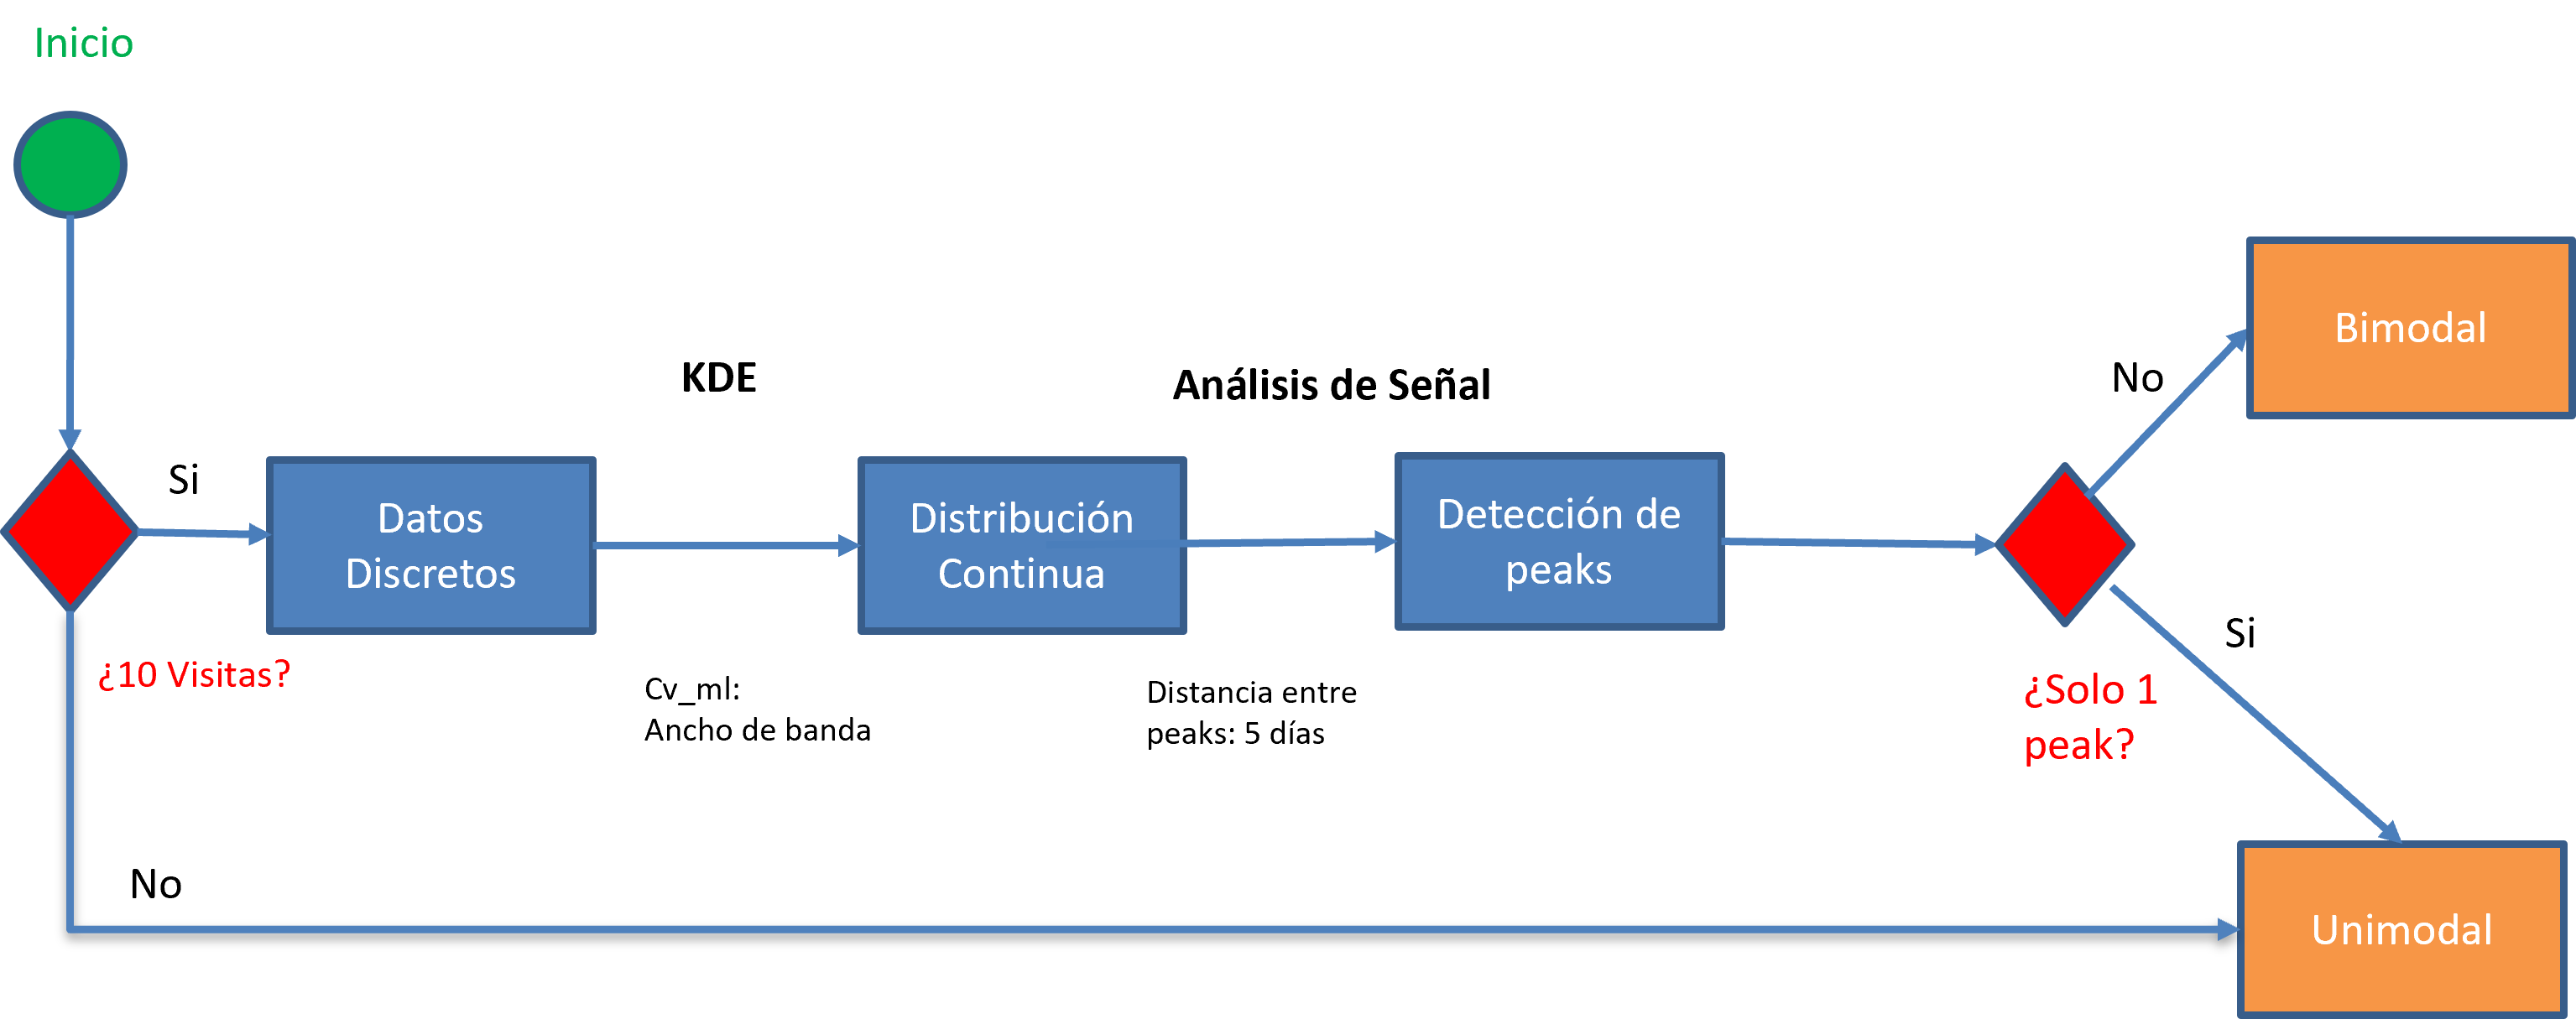

## 4.1 Funcion de Calculo de tiempo entre visitas y Calculo de Percentil

In [40]:
def timebetweenvisits(df_transaccion):
    """
    Calcula el tiempo entre cada visita (unidad: dias)

    Parameters
    ----------
    df_cliente : Dataframe
        Dataframe que contiene la información de por cliente.
        
    Returns
    -------
    tbv : Lista
        Lista que contiene la diferencia entre los días asistidos

    """
    fechas = df_transaccion['Fecha'].reset_index(drop=True)    
    lista = [fechas[k+1] - fechas[k] for k in range(0,len(fechas)-1)]
    tbv = [f.days for f in lista]        
    return tbv
    
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def MAD(x):
    B=stats.median_absolute_deviation(x)
    return B


## 4.2 Procesamiento

**Nos aseguramos de que la base de transacciones correspondan exactamente a los mismos clientes que estan en la base de clientes**

In [41]:
clientes=list(df_clientes['id'].unique())
clientes2=df_transacciones['id'].loc[df_transacciones['id'].isin(clientes)].unique()
df_transacciones=df_transacciones[df_transacciones['id'].isin(clientes2)]
df_transacciones.shape

(958421, 5)

**Creamos multiples listas por cliente para procesar en paralelo**

In [42]:
lista_df = [df_transacciones.loc[df_transacciones['id']== x ] for x in clientes2]

In [43]:
lista_df

[      id    val      Fecha       dia  fin_de_semana
 0  10003    481 2022-03-17  4 Jueves              0
 1  10003  35682 2022-05-05  4 Jueves              0,
       id val      Fecha          dia  fin_de_semana
 2  10004  28 2022-03-31     4 Jueves              0
 3  10004   3 2022-04-13  3 Miercoles              0
 4  10004   6 2022-04-15    5 Viernes              0,
         id     val      Fecha        dia  fin_de_semana
 5    10007   64691 2021-08-07   6 Sabado              1
 6    10007   17082 2021-08-08  7 Domingo              1
 7    10007  126454 2021-08-13  5 Viernes              0
 8    10007  101618 2021-08-14   6 Sabado              1
 9    10007   53192 2021-08-15  7 Domingo              1
 ..     ...     ...        ...        ...            ...
 142  10007   27555 2022-07-01  5 Viernes              0
 143  10007   78846 2022-07-02   6 Sabado              1
 144  10007   13985 2022-07-03  7 Domingo              1
 145  10007   33690 2022-07-22  5 Viernes              0


**Iniciamos el multiprocesamiento para cada lista usando 15 nucleos  y medimos tiempo en realizar esta tarea**

In [44]:
s = datetime.now()

num_processes = 15
    
with Pool(num_processes) as pool:
    print("Starting multiprocess")          
    results_list_tbv = pool.map(timebetweenvisits,lista_df) 
    
for x in results_list_tbv: x.insert(0,0)
    
e = datetime.now()    
print(e-s)
    


Starting multiprocess
0:01:24.439349


**Finalmente creamos el campo time_diff que el tiempo entre visitas entre cada fecha**

In [45]:
df_transacciones['time_diff']=[val for sublista in results_list_tbv for val in sublista]

In [46]:
df_transacciones.head(25)

,id,val,Fecha,dia,fin_de_semana,time_diff
0,10003,481,2022-03-17,4 Jueves,0,0
1,10003,35682,2022-05-05,4 Jueves,0,49
2,10004,28,2022-03-31,4 Jueves,0,0
3,10004,3,2022-04-13,3 Miercoles,0,13
4,10004,6,2022-04-15,5 Viernes,0,2
5,10007,64691,2021-08-07,6 Sabado,1,0
6,10007,17082,2021-08-08,7 Domingo,1,1
7,10007,126454,2021-08-13,5 Viernes,0,5
8,10007,101618,2021-08-14,6 Sabado,1,1
9,10007,53192,2021-08-15,7 Domingo,1,1


**Filtramos valores mayores a cero que corresponden a los valores agregado en la primera fecha para poder calcular el tiempo entre visitas**

In [47]:
df_transacciones=df_transacciones[df_transacciones['time_diff']>0]
df_transacciones.shape

(825477, 6)

**Calculamos estadigrafos descriptivos por cliente como media, mediana, desviación estandar, valores minimos, maximos y percentiles**

In [48]:
df_tot = df_transacciones.groupby('id')['time_diff'].agg([np.count_nonzero, np.mean, np.std, np.median, np.var, np.min, np.max,percentile(25), percentile(75),percentile(90)])   
df_tot   

,count_nonzero,mean,std,median,var,amin,amax,percentile_25,percentile_75,percentile_90
id,,,,,,,,,,
10003,1,49.000000,NaN,49.0,NaN,49,49,49.00,49.00,49.0
10004,2,7.500000,7.778175,7.5,60.500000,2,13,4.75,10.25,11.9
10007,141,2.482270,2.636564,1.0,6.951469,1,19,1.00,4.00,5.0
10014,23,7.173913,6.945582,5.0,48.241107,1,24,1.00,10.50,17.8
10015,16,6.062500,10.049668,3.0,100.995833,1,43,2.00,5.25,7.0
...,...,...,...,...,...,...,...,...,...,...
320048961,4,1.250000,0.500000,1.0,0.250000,1,2,1.00,1.25,1.7
320049091,1,2.000000,NaN,2.0,NaN,2,2,2.00,2.00,2.0
320049119,1,1.000000,NaN,1.0,NaN,1,1,1.00,1.00,1.0


**Mucho de los clientes tienen solo 1 visita por lo que no es posible calcular el tiempo entre visitas para estos clientes. Por lo tanto filtraremos aquellos clientes que tengan menos de 10 visita ya que no se puede sacar conclusiones correctas sobre los estadigrafos si no poseemos un numero importante de visitas**

In [49]:
df_tot1=df_tot[df_tot['count_nonzero']>10]

<AxesSubplot:xlabel='count_nonzero', ylabel='Count'>

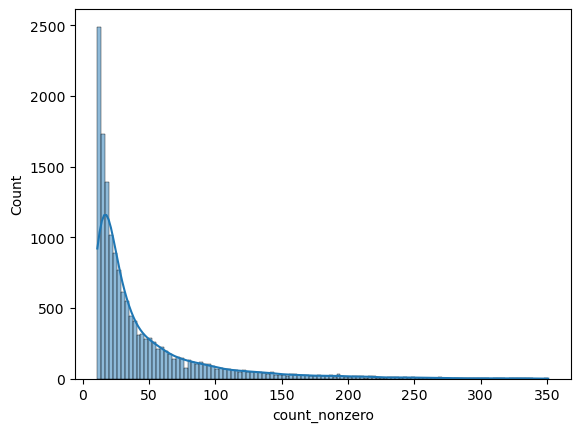

In [50]:
sns.histplot(data=df_tot1, x="count_nonzero",kde=True)

In [51]:
df_tot1.describe()

,count_nonzero,mean,std,median,var,amin,amax,percentile_25,percentile_75,percentile_90
count,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000
mean,44.506225,11.179639,14.359208,6.154066,330.000911,1.327584,59.069706,3.187751,12.745299,24.104727
std,46.603034,7.043057,11.127538,4.906991,516.960984,1.056323,40.507332,2.758468,9.546548,17.952338
min,11.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,16.000000,5.323077,5.773610,2.000000,33.334569,1.000000,28.250000,1.000000,5.750000,10.000000
50%,26.000000,9.771429,11.566608,5.000000,133.786433,1.000000,50.000000,2.000000,10.000000,19.850000
75%,53.000000,15.954004,20.213798,8.000000,408.597630,1.000000,79.000000,4.500000,18.000000,34.100000
max,351.000000,32.090909,85.011122,36.000000,7226.890909,14.000000,295.000000,25.250000,61.000000,148.000000


**Finalmente trabajaremos con 15.422 clientes que poseen 10 o mas visitas.**
1. Estos clientes tienen un tiempo entre visitas promedio de 11 dias
2. Poseen una mediana de 6 dias entre visitas
3. En promedio los clientes presentan 44 visitas (count_nonzero)
4. Exite una alta dispersion en el tiempo entre visitas por lo que introduciremos el concepto de MAD

**Median Absolute Deviation (MAD) es una medida de dispersión similar a la desviación estándar pero más robusta a los valores atípicos. El MAD es una medida de variabilidad que indica la distancia promedio entre las observaciones y su mediana.**


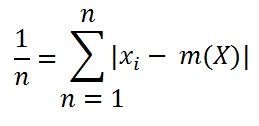

**Filtramos el dataframe de transacciones para los clientes con los que finalmente trabajaremos**

In [53]:
df_transacciones1=df_transacciones[df_transacciones['id'].isin(df_tot1.index)]
df_transacciones1.shape

(686375, 6)

In [54]:
df_transacciones1.head(25)

,id,val,Fecha,dia,fin_de_semana,time_diff
6,10007,17082,2021-08-08,7 Domingo,1,1
7,10007,126454,2021-08-13,5 Viernes,0,5
8,10007,101618,2021-08-14,6 Sabado,1,1
9,10007,53192,2021-08-15,7 Domingo,1,1
10,10007,18615,2021-08-20,5 Viernes,0,5
11,10007,16329,2021-08-21,6 Sabado,1,1
12,10007,54902,2021-08-22,7 Domingo,1,1
13,10007,41477,2021-08-27,5 Viernes,0,5
14,10007,79667,2021-08-28,6 Sabado,1,1
15,10007,6051,2021-08-29,7 Domingo,1,1


**Caculamos el MAD para cada cliente**

In [55]:
mad = df_transacciones1.groupby(['id']).apply(lambda x: x['time_diff'].mad())
mad

id
10007         1.911775
10014         5.429112
10015         4.851562
10025         3.118989
10027        14.688091
               ...    
320045827     1.988166
320046524     5.239669
320046704     1.833333
320046930     2.333333
320047898     1.041420
Length: 15422, dtype: float64

(array([4862., 4129., 2765., 1817., 1065.,  471.,  218.,   65.,   23.,
           7.]),
 array([ 0.        ,  4.65619835,  9.31239669, 13.96859504, 18.62479339,
        23.28099174, 27.93719008, 32.59338843, 37.24958678, 41.90578512,
        46.56198347]),
 <BarContainer object of 10 artists>)

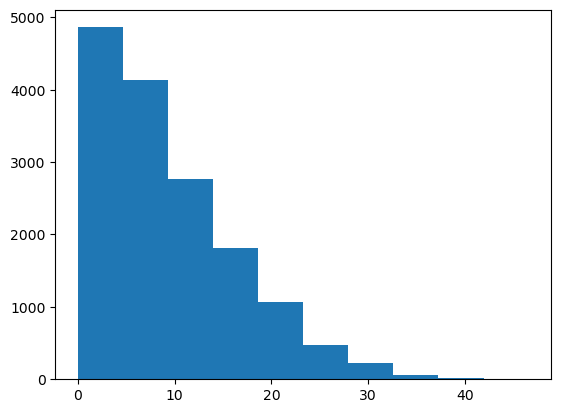

In [56]:
plt.hist(mad)

**Filtraremos aquellos clientes que tengan un MAD mayor a 30**

In [57]:
mad.to_frame(name="MAD")

,MAD
id,
10007,1.911775
10014,5.429112
10015,4.851562
10025,3.118989
10027,14.688091
...,...
320045827,1.988166
320046524,5.239669
320046704,1.833333


In [58]:
mad1=mad[mad<30]
mad1

id
10007         1.911775
10014         5.429112
10015         4.851562
10025         3.118989
10027        14.688091
               ...    
320045827     1.988166
320046524     5.239669
320046704     1.833333
320046930     2.333333
320047898     1.041420
Length: 15230, dtype: float64

In [59]:
df_transacciones2=df_transacciones1[df_transacciones1['id'].isin(mad1.index)]
df_transacciones2.shape

(684080, 6)

# 5. Resultados

## 5.1. Resultados agregados por categoria cliente

**Hacemos un merge de los ambos dataframe**

In [61]:
df_tot2=df_tot1.reset_index()
df_tot3=pd.merge(df_clientes,df_tot2,on='id', how='inner')
df_tot3=df_tot3[df_tot3['id'].isin(mad1.index)]
df_tot3

,id,GENERO,EDAD,RANGO_ETARIO,CATEGORIA,count_nonzero,mean,std,median,var,amin,amax,percentile_25,percentile_75,percentile_90
0,89763,H,41.0,30-44,Categoria_2,15,20.600000,20.628690,13.0,425.542857,1,68,3.50,31.50,47.8
1,130000815,M,72.0,65+,Categoria_2,49,6.938776,6.838641,4.0,46.767007,1,32,3.00,7.00,15.4
2,130018965,H,79.0,65+,Categoria_1,12,19.500000,31.887587,2.0,1016.818182,1,101,1.00,26.75,58.4
3,130190162,H,31.0,30-44,Categoria_3,35,1.628571,1.716455,1.0,2.946218,1,9,1.00,1.00,3.0
4,130069664,M,86.0,65+,Categoria_1,17,17.176471,53.138069,3.0,2823.654412,1,223,2.00,7.00,10.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,46423,M,69.0,65+,Categoria_1,16,17.750000,37.449522,2.0,1402.466667,1,145,1.00,13.00,44.5
15418,306719,M,74.0,65+,Categoria_3,28,8.392857,3.258485,8.0,10.617725,3,14,7.00,12.00,12.3
15419,66277,H,52.0,45-64,Categoria_1,24,14.541667,20.803384,6.5,432.780797,1,91,3.75,16.75,34.7
15420,11681,H,66.0,65+,Categoria_2,13,6.000000,12.897028,2.0,166.333333,1,48,1.00,3.00,9.4


**El la siguente tabla podemos ver el promedio de los promedios de tiempo entre visita agrupado por categoria cliente**

In [62]:
df_tot3.groupby('CATEGORIA', sort = False)['mean'].agg([np.count_nonzero,np.mean])   

,count_nonzero,mean
CATEGORIA,,
Categoria_2,4867,10.129920
Categoria_1,6555,14.228066
Categoria_3,2551,7.098864
Categoria_4,1257,5.340573


[Text(0.5, 1.0, 'Promedio de Tiempo entre visitas Por categoria Tarjeta')]

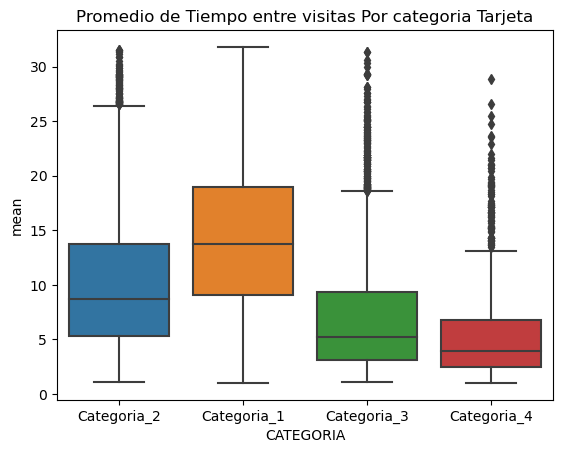

In [64]:
sns.boxplot(x="CATEGORIA", y="mean", data=df_tot3).set(title='Promedio de Tiempo entre visitas Por categoria Tarjeta')

**Se cumple la hipotesis planteada, es decir, el tiempo promedio entre visita es menor para aquellos clientes de mayor valor**

**Con el siguente grafico podemos evaluar la distribución de los tiempo entr visita para cada una de las categorias de cliente**

[Text(0.5, 1.0, 'Distribución de tiempo entre visitas por categoria')]

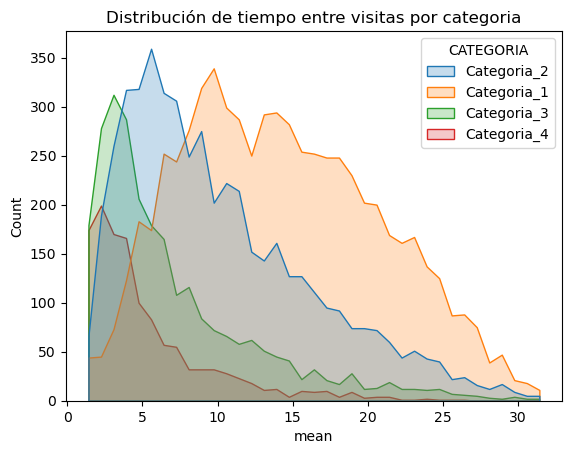

In [65]:
sns.histplot(df_tot3, x="mean", hue="CATEGORIA", element="poly").set(title='Distribución de tiempo entre visitas por categoria')

**Si bien es cierto que había que hacer un test de distribución para concluir con evidencia estadistica, aparentemente los clientes Silver siguen una distribución normal y los clientes Gold, Platinum y Diamon, parecen tener una distribución normal con Right Skewed o Long Tail.**

## 5.2 Resultados de Clientes Bimodales

In [206]:
from scipy.stats import median_abs_deviation

**Se definen funciones necesarias para ejecutar el calculo de KDE y almacenar los estadigrafos de la primera moda y la segunda moda**

In [207]:
def calcular_tbv_cliente2(df_cliente, plot1, min_visitas = 10 ,  dist_entre_peaks = 5):
    """
    
    Calcula el peak de la distribucion del tiempo entre visitas. Entrega el peak de la distribucion, 
    desviacion estandar, median absolute deviation (MAD), y MAD sobre el peak, para un solo cliente.
    Esta funcion actualmente funciona para distribuciones con hasta dos modos
    
    Parameters
    ----------
    df_cliente :  Dataframe
        Dataframe que contiene la información de id,Puntos,Fecha,weekday,FDS,feriado,feriado2,
        antesdeferiado,antesdeferiado2,feriado_final,estival,time_diff por cliente.
    plot1: Boolean
        Se define si se desea plotear el histograma y el ajuste de distribución
    min_visitas : int, optional
        Cantidad mínima de visitas que se debe tener para analizar el comportamiento del tiempo
        entre visitas. The default is 10.
    dist_entre_peaks : int, optional
        Distancia en el eje x de la cantidad de días que debe haber entre los peaks de la distribución. 
        The default is 3.


    Returns
    -------
    Lista de estadisticas descriptivas: Lista
        Información descriptiva de las dos primeras modas que tiene cada cliente: La información de salida
        es: cliente, promedio, número de visitas, percentil 50, std, MAD, coeficiente de variación

    """
    
    # Se crea una lista de dos dimensiones (debido a que solo se extrae la información de dos modas) 
    # por cada caracteristica descriptiva. La lista contiene [-1,-1], para que en el caso de que no haya 
    # una segunda moda, el valor de la celda no quede vacía.
    cmd = [-1]*8
    cmd_oficial = [-1]*2
    n_visits = [-1]*8
    n_visits_oficial = [-1]*2
    p50 = [-1]*8
    standv = [-1]*8
    MAD = [-1]*8
    cov = [-1]*8 
 
    
    # Se calcula el tiempo entre visita del cliente
    data = timebetweenvisits(df_cliente)
    
    # Se extrae el id del cliente
    cliente = df_cliente['id'].iloc[0]
   
    
    # Se asume una distribución normal de los datos, y se calcula la media y la varianza
    mu = np.mean(data)
    sigma = max(np.std(data), 1) 
    
    # Se acotan los datos para aquellos que se encuentren entre mu+- 3*sigma
    xvals = np.arange(0, (mu + 3*sigma + 1).astype(int))
    
    
    # Descomentar en caso de graficar el histograma de asistencia
    if plot1 == True:
        #plt.axvline(x = mu, ymin=0, ymax=25,color = 'black')
        plt.hist(data,bins = 100)
        plt.xlabel('Días')
        plt.ylabel('Frecuencia')


    # En el caso de que un cliente tenga menos visitas que una cota (10),
    # se asume una distribución unimodal y se calculas las estadisticas descriptivas 
    # a partir de la cantidad de visitas existentes.

    if (len(data) < min_visitas): 
        cmd_oficial[0] = mu
        n_visits_oficial[0] = len(data)        
        try:
            p50[0] = np.percentile(data, 50, axis=0)
        except:
            p50[0] = None         
        standv[0] = sigma
        MAD[0] = median_abs_deviation(data)
        cov[0] = MAD[0]/cmd[0]


    # En el caso de que un cliente tenga más o igual visitas que una cota (10),
    # se analiza si tiene un comportamiento unimodal o bimodal
        
    else:
        try:
            # Se calcula una distribución continua para los datos entre visitas
            stats_models_cv = KDEMultivariate(data, var_type = 'c', bw = 'cv_ml').pdf(xvals)
            # Se define que la cota minima para los peaks corresponde al 10% de la altura máxima.
            cota_altura = np.max(stats_models_cv)*0.1

            # Se buscan los peaks de la distribución que tengan 3 días de distancia 
            peaks, dic = scipy.signal.find_peaks( stats_models_cv, height = cota_altura, distance = dist_entre_peaks) 
            
        
            if plot1 == True:
                 plt.plot(stats_models_cv*180)
                 plt.axvline(x = peaks[0], ymin=0, ymax=25,color = 'black',linestyle ='--')
                 plt.axvline(x = peaks[1], ymin=0, ymax=25,color = 'black',linestyle ='--')

            
        except:
            # Si el análisis anterior genera algún error, se asume un análisis unimodal y se
            # calculas las estadisticas descriptivas a partir de la cantidad de visitas existentes.
            cmd_oficial[0] = mu
            p50[0] = np.percentile(data, 50, axis=0)         
            n_visits_oficial[0] = len(data)
            standv[0] = sigma
            MAD[0] = median_abs_deviation(data)
            cov[0] = MAD[0]/cmd[0]
        
         
        # Se define los peaks como los promedios
        cmd = peaks
        #Calculo las distancias de todos los tiempos entre visitas con respecto a todos los peaks
        distancias = distance.cdist(peaks.reshape(-1,1), np.array(data).reshape(-1,1), 'euclidean')
        #Selecciono los indices de menor distancia entre los tiempos entre visitas y los promedios
        indice_peak = np.argmin(distancias,axis=0)
        mound = [[] for x in range(len(peaks))]
              

        # Busco las posibles agrupaciones a las que puede pertenecer el punto 
        for j in range(len(data)):
            #Se consulta si es que el dato se ubica a una distancia de sigma/2 con respecto a una moda.
            #De ser asi,Incoporo el dato en mound, especificamente en el indice de la moda a la que pertenece
            if data[j] < cmd[indice_peak[j]] + sigma/2 and data[j]>cmd[indice_peak[j]] - sigma/2:
                mound[indice_peak[j]].append(data[j])
                
                
           
        # Se define el número de visitas por moda como la cantidad de elementos que tiene cada agrupación
        n_visits = [len(x) for x in mound]
       
      
        try:
            # En caso de que tenga menos de dos peak, se asigna una distribución bimodal.
            #Se guardan 2 indices de las modas que tienen mayor cantidad de tiempos entre visitas, y se
            #define a la primera moda como la moda más grande      
            numero_moda = np.argsort(n_visits)[::-1][0:2]
            # En caso de que el cliente tenga más de 1 peak, se define un comportamiento bimodal si es que el minimo
            # peak es mayor al 25% del peak más grande. En caso de que no se cumpla esta condición, se asume 
            # distribución unimodal con respecto al peak mayor
            if n_visits[numero_moda[1]]< 0.25*n_visits[numero_moda[0]]:
                numero_moda = [numero_moda[0]]
        except: 
            # Si es que lo anterior tira error, es porque el largo de peak es uno, por lo que se
            #asigna una distribución unimonal considerando el único peak detectado
            numero_moda = [0]
            
            
        #Se asume una distribución bimodal y se calculan las estadisticas descriptivas
        for i in range(len(numero_moda)):
            cmd_oficial[i] = cmd[numero_moda[i]]
            n_visits_oficial[i] = n_visits[numero_moda[i]]
            p50[i] = np.percentile(mound[numero_moda[i]], 50, axis=0)         
            standv[i] = np.std(mound[numero_moda[i]])    
            mad = median_abs_deviation(mound[numero_moda[i]])
            MAD[i] = mad
            cov[i] = mad/cmd[numero_moda[i]]
        
                
    return [cliente, cmd_oficial[0], n_visits_oficial[0],p50[0], standv[0], MAD[0], cov[0], cmd_oficial[1], n_visits_oficial[1],p50[1], standv[1], MAD[1], cov[1]]


In [208]:
def calcular_tbv_cliente(df_cliente, plot1 = False, min_visitas = 10 , dist_entre_peaks = 5):
    """Calcula el peak de la distribucion del tiempo entre visitas. Entrega el peak de la distribucion, 
    desviacion estandar, median absolute deviation (MAD), y MAD sobre el peak, para un solo cliente.
    Esta funcion actualmente funciona para distribuciones con hasta dos modos
    
    Parameters
    ----------
    df_cliente :  Dataframe
        Dataframe que contiene la información de id, time_diff por cliente.
    min_visitas : int, optional
        Cantidad mínima de visitas que se debe tener para analizar el comportamiento del tiempo
        entre visitas. Valor por defecto 10.
    dist_entre_peaks : int, optional
        Distancia en el eje x de la cantidad de días que debe haber entre los peaks de la distribución. 
        Valor por defecto es de 5.


    Returns
    -------
    Lista de estadisticas descriptivas: Lista
        Información descriptiva de las dos primeras modas que tiene cada cliente: La información de salida
        es: cliente, promedio, número de visitas, percentil 50, std, MAD, coeficiente de variación

    """
    # Se crea una lista de dos dimensiones (debido a que solo se extrae la información de dos modas) 
    # por cada caracteristica descriptiva. La lista contiene [-1,-1], para que en el caso de que no haya 
    # una segunda moda, el valor de la celda no quede vacía.
    
    cmd = [-1]*2
    n_visits = [-1]*2
    standv = [-1]*2
    MAD = [-1]*2
    cov = [-1]*2
    
    # Se calcula el tiempo entre visita del cliente
    data = timebetweenvisits(df_cliente)
    
    # Se extrae el id del cliente
    cliente = df_cliente['id'].iloc[0]
    
    # Se asume una distribución normal de los datos, y se calcula la media y la varianza
    
    mu = np.mean(data)
    sigma = max(np.std(data), 1) ## en caso que la de sea demasiado pequeña
    
    # Se acotan los datos para aquellos que se encuentren entre mu+- 3*sigma
    xvals = np.arange(0, (mu + 3*sigma + 1).astype(int))
    
    if plot1==True:         
        plt.hist(data,bins = 10)
        plt.xlabel('Días')
        plt.ylabel('Frecuencia')
    
    else:
        pass
    
    # En el caso de que un cliente tenga menos visitas que una cota (10),
    # se asume una distribución unimodal y se calculas las estadisticas descriptivas 
    # a partir de la cantidad de visitas existentes.
    
    if (len(data) < min_visitas):  
        cmd[0] = mu
        n_visits[0] = len(df_cliente)
        standv[0] = sigma
        MAD[0] = median_abs_deviation(data)
        cov[0] = MAD[0]/cmd[0]

    # En el caso de que un cliente tenga más o igual visitas que una cota (10),
    # se analiza si tiene un comportamiento unimodal o bimodal
    # En caso de que el cliente tenga más de 1 peak, se define un comportamiento bimodal si es que el minimo

    else:
        try:
            # Se calcula una distribución continua para los datos entre visitas
            stats_models_cv = KDEMultivariate(data, var_type = 'c', bw = 'cv_ml').pdf(xvals) 
            MADi = median_abs_deviation(stats_models_cv)
            # Se buscan los peaks de la distribución que tengan 5 días de distancia 
            peaks, dic = scipy.signal.find_peaks( stats_models_cv, height = MADi, distance = dist_entre_peaks) 
            
            if plot1==True:
                plt.plot(stats_models_cv*50)
                plt.axvline(x = peaks[0], ymin=0, ymax=25,color = 'black',linestyle ='--')
                plt.axvline(x = peaks[1], ymin=0, ymax=25,color = 'black',linestyle ='--')
            else:
                pass
    
        except:
            cmd[0] = mu
            n_visits[0] = len(df_cliente)
            standv[0] = sigma
            MAD[0] = median_abs_deviation(data)
            cov[0] = MAD[0]/cmd[0]
        

            # Se asume que el promedio de cada moda es el peak encontrado
            # Se crea un intervalo con rango de sigma/2 con respecto a una moda.
            # se filtran los datos que esten en ese rango.
            
        for kk in range( min(len(peaks),2) ):
            cmd[kk] = peaks[kk]
            idx = (data < cmd[kk] + sigma/2) & (data > cmd[kk] - sigma/2)
            data = np.array(data)
            mound = data[idx]
            n_visits[kk] = len(mound) + 1
            standv[kk] = np.std(mound) 
            
            mad = median_abs_deviation(mound)
            MAD[kk] = mad
            cov[kk] = mad/cmd[kk]
            
    return [cliente, cmd[0], n_visits[0], standv[0], MAD[0], cov[0], cmd[1], n_visits[1], standv[1], MAD[1], cov[1]]


In [209]:
def calcular_tbv(df, plot = False, min_visitas = 10 , dist_entre_peaks = 5, savefig = False ):
    """
    Ejecuta "calcular_tbv_1cliente" para todos los clientes en un dataframe.
    Devuelve los resultados en un dataframe.


    Parameters
    ----------
    df : Dataframe
        Dataframe que contiene la información de los clientes incluyendo time_diff por cliente.
    min_visitas : int, optional
         Cantidad mínima de visitas que se debe tener para analizar el comportamiento del tiempo
         entre visitas. 
    dist_entre_peaks : int, optional
         Distancia en el eje x de la cantidad de días que debe haber entre los peaks de la distribución. 
    Returns
    -------
    df_res : DataFrame
        Dataframne que contiene las estadisticas descriptivas de cada cliente.

    """
    
    # Cantidad única de clientes
    clientes = df['id'].unique()    
    res = []
    
    qq = 0
    tot_clientes = len(clientes)
    
    for cliente in clientes:
        
        if (qq%100 == 0):
            print("Calculando cliente {} de un total de {}".format(qq, tot_clientes) )
        
        df_cliente = df.loc[ df['id'] == cliente  ]
        

        playerid, cmd0, n_visits0, standv0, MAD0, cov0, cmd1, n_visits1, standv1, MAD1, cov1 = calcular_tbv_cliente(df_cliente, plot1 = plot, min_visitas = 10 , dist_entre_peaks = 5 )
                                                            
        
        res.append([playerid, cmd0, n_visits0, standv0, MAD0, cov0, cmd1, n_visits1, standv1, MAD1, cov1])

        qq += 1
        
        
    df_res = pd.DataFrame(data = res, columns = ['id', 'peak1', 'n_visitas1' ,'standv1', 'MAD1', 'cov1', 'peak2', 'n_visitas2', 'standv2', 'MAD2', 'cov2'])
    
    return df_res

In [210]:
def calcular_tbv2(df, plot = False, min_visitas = 10 , dist_entre_peaks = 5, savefig = False ):
    """
    Ejecuta "calcular_tbv_1cliente" para todos los clientes en un dataframe.
    Devuelve los resultados en un dataframe.


    Parameters
    ----------
    df : Dataframe
        Dataframe que contiene la información de los clientes incluyendo time_diff por cliente.
    min_visitas : int, optional
         Cantidad mínima de visitas que se debe tener para analizar el comportamiento del tiempo
         entre visitas. 
    dist_entre_peaks : int, optional
         Distancia en el eje x de la cantidad de días que debe haber entre los peaks de la distribución. 
    Returns
    -------
    df_res : DataFrame
        Dataframne que contiene las estadisticas descriptivas de cada cliente.

    """
    
    # Cantidad única de clientes
    clientes = df['id'].unique()    
    res = []
    
    qq = 0
    tot_clientes = len(clientes)
    
    for cliente in clientes:
        
        if (qq%100 == 0):
            print("Calculando cliente {} de un total de {}".format(qq, tot_clientes) )
        
        df_cliente = df.loc[ df['id'] == cliente  ]
        

        playerid, cmd0, n_visits0,p50_0, standv0, MAD0, cov0, cmd1, n_visits1, p50_1, standv1, MAD1, cov1  = calcular_tbv_cliente2(df_cliente, plot1 = plot, min_visitas = 10 , dist_entre_peaks = 5 )
                                                            
        
        res.append([playerid, cmd0, n_visits0,p50_0, standv0, MAD0, cov0, cmd1, n_visits1,p50_1, standv1, MAD1, cov1])

        qq += 1
        
        
    df_res = pd.DataFrame(data = res, columns =['player_id', 'peak1', 'n_visitas1' , 'p50_1','standv1', 'MAD1', 'cov1', 'peak2', 'n_visitas2', 'p50_2','standv2', 'MAD2', 'cov2'])
    
    return df_res

**Utilizaremos un cliente de prueba para graficar ambas la distribución KDE sus modas y estadigrafos**

In [211]:
df=df_transacciones2[df_transacciones2['id']==11138]
df.head()

,id,val,Fecha,dia,fin_de_semana,time_diff
9843,11138,3703,2021-08-15,7 Domingo,1,7
9844,11138,4491,2021-08-22,7 Domingo,1,7
9845,11138,3897,2021-09-12,7 Domingo,1,21
9846,11138,7364,2021-09-24,5 Viernes,0,12
9847,11138,3248,2021-09-30,4 Jueves,0,6


In [214]:
df_resultado = calcular_tbv2(df, plot = False)
df_resultado

Calculando cliente 0 de un total de 1


,player_id,peak1,n_visitas1,p50_1,standv1,MAD1,cov1,peak2,n_visitas2,p50_2,standv2,MAD2,cov2
0,11138,7,28,7.0,1.10887,1.0,0.142857,2,14,1.0,0.820652,0.0,0.0


Calculando cliente 0 de un total de 1


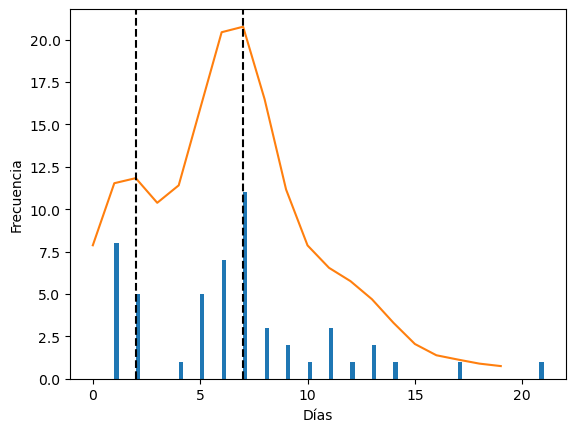

In [215]:
df_resultado = calcular_tbv2(df, plot = True)

**Calculando para todos los clientes del dataframe**

In [116]:
df_rus = calcular_tbv(df=df_transacciones2, plot = False)
df_rus

Calculando cliente 0 de un total de 15230


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: divide by zero encountered in log
  L += func(f_i)


Calculando cliente 100 de un total de 15230
Calculando cliente 200 de un total de 15230
Calculando cliente 300 de un total de 15230
Calculando cliente 400 de un total de 15230
Calculando cliente 500 de un total de 15230
Calculando cliente 600 de un total de 15230
Calculando cliente 700 de un total de 15230


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])


Calculando cliente 800 de un total de 15230
Calculando cliente 900 de un total de 15230
Calculando cliente 1000 de un total de 15230
Calculando cliente 1100 de un total de 15230
Calculando cliente 1200 de un total de 15230
Calculando cliente 1300 de un total de 15230
Calculando cliente 1400 de un total de 15230
Calculando cliente 1500 de un total de 15230
Calculando cliente 1600 de un total de 15230
Calculando cliente 1700 de un total de 15230
Calculando cliente 1800 de un total de 15230
Calculando cliente 1900 de un total de 15230
Calculando cliente 2000 de un total de 15230
Calculando cliente 2100 de un total de 15230
Calculando cliente 2200 de un total de 15230
Calculando cliente 2300 de un total de 15230
Calculando cliente 2400 de un total de 15230
Calculando cliente 2500 de un total de 15230
Calculando cliente 2600 de un total de 15230
Calculando cliente 2700 de un total de 15230
Calculando cliente 2800 de un total de 15230
Calculando cliente 2900 de un total de 15230
Calculando c

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:790: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Calculando cliente 5300 de un total de 15230
Calculando cliente 5400 de un total de 15230
Calculando cliente 5500 de un total de 15230
Calculando cliente 5600 de un total de 15230
Calculando cliente 5700 de un total de 15230
Calculando cliente 5800 de un total de 15230
Calculando cliente 5900 de un total de 15230
Calculando cliente 6000 de un total de 15230
Calculando cliente 6100 de un total de 15230
Calculando cliente 6200 de un total de 15230
Calculando cliente 6300 de un total de 15230
Calculando cliente 6400 de un total de 15230
Calculando cliente 6500 de un total de 15230
Calculando cliente 6600 de un total de 15230
Calculando cliente 6700 de un total de 15230
Calculando cliente 6800 de un total de 15230
Calculando cliente 6900 de un total de 15230
Calculando cliente 7000 de un total de 15230
Calculando cliente 7100 de un total de 15230
Calculando cliente 7200 de un total de 15230
Calculando cliente 7300 de un total de 15230
Calculando cliente 7400 de un total de 15230
Calculando

,id,peak1,n_visitas1,standv1,MAD1,cov1,peak2,n_visitas2,standv2,MAD2,cov2
0,10007,1,97,0.291481,0.0,0.0,-1,-1,-1.000000,-1.0,-1.000000
1,10014,2,13,1.354006,0.0,0.0,8,9,2.000000,1.5,0.187500
2,10015,3,15,1.953542,1.5,0.5,-1,-1,-1.000000,-1.0,-1.000000
3,10025,1,98,0.341920,0.0,0.0,12,14,1.327898,1.0,0.083333
4,10027,6,16,3.492214,0.0,0.0,-1,-1,-1.000000,-1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...
15225,320045827,1,15,0.410326,0.0,0.0,6,7,0.577350,0.0,0.000000
15226,320046524,1,8,1.245400,1.0,1.0,20,3,0.000000,0.0,0.000000
15227,320046704,5,6,0.894427,1.0,0.2,-1,-1,-1.000000,-1.0,-1.000000
15228,320046930,2,6,0.489898,0.0,0.0,-1,-1,-1.000000,-1.0,-1.000000


In [117]:
df_select=df_rus[(df_rus['peak1']>1) & (df_rus['peak2']>1 ) & (df_rus['n_visitas2']>0.5*df_rus['n_visitas1'] )]
df_select

,id,peak1,n_visitas1,standv1,MAD1,cov1,peak2,n_visitas2,standv2,MAD2,cov2
1,10014,2,13,1.354006,0.0,0.000000,8,9,2.000000,1.5,0.187500
18,10205,7,12,1.991718,1.0,0.142857,26,7,3.337497,1.0,0.038462
52,10494,5,13,2.177856,1.5,0.300000,28,7,2.160247,1.0,0.035714
131,11138,2,15,0.820652,0.0,0.000000,7,29,1.108870,1.0,0.142857
151,11228,8,7,1.598611,1.0,0.125000,22,4,2.624669,1.0,0.045455
...,...,...,...,...,...,...,...,...,...,...,...
15073,320004368,7,10,3.269764,1.0,0.142857,13,10,4.573137,2.0,0.153846
15076,320006055,2,10,0.566558,0.0,0.000000,7,16,1.087300,1.0,0.142857
15097,320018939,7,7,1.462494,0.5,0.071429,13,5,1.224745,0.5,0.038462
15098,320020195,5,19,1.583090,2.0,0.400000,13,10,1.286204,1.0,0.076923


# 6.  Conclusión

En este trabajo se contestarón las preguntas iniciales que motivaron este estudio. 

- Se cumple la hipotesis planteada, es decir, el tiempo promedio entre visita es menor para aquellos clientes de mayor valor. 


- Se contruyó la distribución de tiempos entre visitas agrupapando por la categoria de los clientes y se pudo evaluar la diferencia en los estadigrafos de estas distribuciones. Se puede concluir tambien que los clientes categoria_1 siguen una distribución normal y los clientes de categoría 2, 3 y 4, tienen una distribución normal con Right Skewed o Long Tail.


- Se confirma la hipotesis que existen clientes que presentan una distribución bimodal, especificamente 690 clientes presentan una segunda moda con un peak de al menos un 50% de la primera moda.


- Finalmente todos estos hallazgos represetan herramientas importantes en la toma de decisiones como input para realizar un modelo de Fuga Personalizado de Cliente.

### 7. Anexo Exploratorio

In [119]:
df_select['diff_visita']=df_select['n_visitas1']-df_select['n_visitas2']
df_select['diff_peak']=df_select['peak1']-df_select['peak2']
df_select

C:\Users\Usuario\AppData\Local\Temp\ipykernel_4596\3983967010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['diff_visita']=df_select['n_visitas1']-df_select['n_visitas2']
C:\Users\Usuario\AppData\Local\Temp\ipykernel_4596\3983967010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['diff_peak']=df_select['peak1']-df_select['peak2']


,id,peak1,n_visitas1,standv1,MAD1,cov1,peak2,n_visitas2,standv2,MAD2,cov2,diff,diff_visita,diff_peak
1,10014,2,13,1.354006,0.0,0.000000,8,9,2.000000,1.5,0.187500,4,4,-6
18,10205,7,12,1.991718,1.0,0.142857,26,7,3.337497,1.0,0.038462,5,5,-19
52,10494,5,13,2.177856,1.5,0.300000,28,7,2.160247,1.0,0.035714,6,6,-23
131,11138,2,15,0.820652,0.0,0.000000,7,29,1.108870,1.0,0.142857,-14,-14,-5
151,11228,8,7,1.598611,1.0,0.125000,22,4,2.624669,1.0,0.045455,3,3,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15073,320004368,7,10,3.269764,1.0,0.142857,13,10,4.573137,2.0,0.153846,0,0,-6
15076,320006055,2,10,0.566558,0.0,0.000000,7,16,1.087300,1.0,0.142857,-6,-6,-5
15097,320018939,7,7,1.462494,0.5,0.071429,13,5,1.224745,0.5,0.038462,2,2,-6
15098,320020195,5,19,1.583090,2.0,0.400000,13,10,1.286204,1.0,0.076923,9,9,-8


In [140]:
df_select = df_select.sort_values(['diff_visita', 'diff_peak'], ascending = [False, False])
df_select.to_csv('output/clientes_output.csv')

Calculando cliente 0 de un total de 1


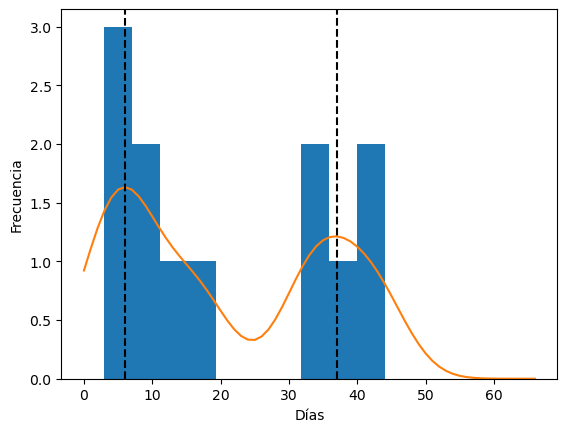

In [220]:
df_resultado = calcular_tbv(df_transacciones2[df_transacciones2['id']==99257], plot = True)